# Columns
price: Price in US dollars ( 326−−18,823)

carat: Carat weight of the diamond (0.2--5.01)

cut: Cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: Color diamond colour, from J (worst) to D (best)

clarity: Clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF(best))

x: Length in mm (0--10.74)

y: Width in mm (0--58.9)

z: Depth in mm (0--31.8)

depth: Total depth percentage = 100* z / mean(x, y) = 200 * z / (x + y) (43--79)

table: Table width of top of diamond relative to widest point (43--95)

## importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Ignoring `palette` because no `hue` variable has been assigned.*")
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import time
from scipy.stats import randint, zscore
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    VotingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    IsolationForest,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Reading data

In [2]:
diamonds = pd.read_csv("train.csv")

## Exploring data

In [3]:
diamonds.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [4]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
diamonds.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
diamonds.describe(include="all")

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152,43152,43152,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,17203,9060,10428,NaN,NaN,NaN,NaN,NaN,NaN
mean,21576.500000,0.797855,NaN,NaN,NaN,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,NaN,NaN,NaN,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,NaN,NaN,NaN,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,NaN,NaN,NaN,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000


In [7]:
diamonds["cut"].value_counts()

cut
Ideal        17203
Premium      11113
Very Good     9658
Good          3881
Fair          1297
Name: count, dtype: int64

In [8]:
diamonds["color"].value_counts()

color
G    9060
E    7832
F    7633
H    6651
D    5421
I    4265
J    2290
Name: count, dtype: int64

In [9]:
diamonds["clarity"].value_counts()

clarity
SI1     10428
VS2      9824
SI2      7432
VS1      6475
VVS2     4041
VVS1     2904
IF       1442
I1        606
Name: count, dtype: int64

Save the order to use it later.

In [10]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

### Findings
1) There's a total of 9 features, 3 categorical (cut, color, clarity), and 6 numerical (carat, depth, table, x, y, z), in addition to Id column which is irrelevant and price which is our target.
2) All categorial features are ranked from worst to best. So, they're all good candidates for OrdinalEncoder.
3) There's no null values, however there's some values that are unrealistically zero.

## Cleaning data

In [11]:
zero_counts = diamonds.eq(0).sum()
zero_all = diamonds[(diamonds['x'] == 0) & (diamonds['y'] == 0) & (diamonds['z'] == 0)]
print("The number of rows that contain zero is: ",diamonds[(diamonds == 0).any(axis=1)].shape[0])
print(zero_counts)
print(zero_all.shape[0])

The number of rows that contain zero is:  17
Id          0
carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           5
y           4
z          17
dtype: int64
4


There are 17 rows that contain zeros. Four of them contain x=y=z=0, One contains x=z=0 And 12 contain only z=0. We can calculate z in the rows where only z is zero from the formula:
depth-percentage = z/mean(x,y). Therefor, z = depth-percentage*mean(x,y)/100

In [12]:
zero_df = diamonds[(diamonds['z'] == 0)]
def handle_zeros(row):
    if row['x'] == 0 or row['y'] == 0:
        return None
    elif row['z'] == 0:
        row['z'] = round(row['depth'] * (row['x'] + row['y']) / 200,2)
    return row


diamonds = diamonds.apply(handle_zeros, axis=1).dropna()

print("After editing. The number of rows contain zeros is:", diamonds[(diamonds == 0).any(axis=1)].shape[0])
print("The rows before replacing zeros in z:")
zero_df.head(17)

After editing. The number of rows contain zeros is: 0
The rows before replacing zeros in z:


,Id,carat,cut,color,clarity,depth,table,price,x,y,z
571,572,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
903,904,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,0.0
1221,1222,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
4980,4981,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
6765,6766,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.0
11221,11222,2.80,Good,G,SI2,63.8,58.0,18788,8.90,8.85,0.0
13727,13728,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,0.0
14265,14266,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
16971,16972,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
21061,21062,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0


In [13]:
handle_zeros_df = diamonds[diamonds['Id'].isin(zero_df['Id'])]
print("The same rows after replacing zeros in z:")
handle_zeros_df.head(12)

The same rows after replacing zeros in z:


,Id,carat,cut,color,clarity,depth,table,price,x,y,z
571,572.0,1.10,Premium,G,SI2,63.0,59.0,3696.0,6.50,6.47,4.09
903,904.0,2.25,Premium,I,SI1,61.3,58.0,15397.0,8.52,8.42,5.19
4980,4981.0,1.50,Good,G,I1,64.0,61.0,4731.0,7.15,7.04,4.54
11221,11222.0,2.80,Good,G,SI2,63.8,58.0,18788.0,8.90,8.85,5.66
13727,13728.0,2.02,Premium,H,VS2,62.7,53.0,18207.0,8.02,7.95,5.01
14265,14266.0,1.01,Premium,F,SI2,59.2,58.0,3837.0,6.50,6.47,3.84
16971,16972.0,1.00,Premium,G,SI2,59.1,59.0,3142.0,6.55,6.48,3.85
21061,21062.0,1.15,Ideal,G,VS2,59.2,56.0,5564.0,6.88,6.83,4.06
27221,27222.0,1.12,Premium,G,I1,60.4,59.0,2383.0,6.71,6.67,4.04
34065,34066.0,1.01,Premium,H,I1,58.1,59.0,3167.0,6.66,6.60,3.85


Now there are no zeros and the values got more realistic. Because the Id column is useless, it is better to drop it now. Then check for the duplicates after dropping Id "because Id column have unique value for each row".

In [14]:
diamonds.drop("Id",axis =1,inplace= True)
diamonds.duplicated().sum()

97

In [15]:
diamonds.drop_duplicates(inplace= True)

Let's check for depth values. As long as we've got the formula, we can check is there is a big difference between the calculated depth and the depth.

In [16]:
data = diamonds.copy()
data["calculated_depth"] = 100*(2 * data["z"] / (data["x"] + data["y"]))
formula_satisfied = abs(data["depth"] - data["calculated_depth"]) <=5
num_discrepancies = ~formula_satisfied.sum()
print(f"Number of rows with discrepancies: {data.shape[0] + num_discrepancies}")
discrepant_rows = data[~formula_satisfied]
discrepant_rows.head()

Number of rows with discrepancies: 23


,carat,cut,color,clarity,depth,table,price,x,y,z,calculated_depth
2244,2.06,Premium,H,SI2,60.0,60.0,16098.0,6.29,6.25,4.96,79.106858
3476,1.09,Ideal,J,VS2,43.0,54.0,4778.0,6.53,6.55,4.12,62.996942
9014,0.55,Very Good,E,VS2,61.0,59.0,1831.0,5.31,5.34,2.25,42.253521
10541,0.51,Very Good,E,VS1,61.8,54.7,1970.0,5.12,5.15,31.80,619.279455
12677,1.00,Fair,D,VS1,55.9,60.0,7083.0,6.77,6.71,4.38,64.985163


In [17]:
diamonds = data[formula_satisfied].drop("calculated_depth", axis =1)

Now let's get rid of outliers values in the table column:

In [18]:
z_scores = stats.zscore(diamonds['table'])
outliers_zscore = diamonds[abs(z_scores-1) >=6]
outliers_zscore.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
15487,0.79,Fair,G,SI1,65.3,76.0,2362.0,5.52,5.13,3.35
21722,0.81,Fair,F,SI2,68.8,79.0,2301.0,5.26,5.20,3.58
26907,0.29,Very Good,E,VS1,62.8,44.0,474.0,4.20,4.24,2.65
32829,2.01,Fair,F,SI1,58.6,95.0,13387.0,8.32,8.31,4.87
37011,1.04,Ideal,I,VS1,62.9,43.0,4997.0,6.45,6.41,4.04


In [19]:
diamonds = diamonds[abs(z_scores-1) <6]
diamonds.describe()

,carat,depth,table,price,x,y,z
count,43021.000000,43021.000000,43021.000000,43021.000000,43021.000000,43021.000000,43021.000000
mean,0.797582,61.747763,57.458402,3928.930546,5.731931,5.733636,3.539467
std,0.473109,1.425784,2.220188,3984.155210,1.119078,1.111084,0.690701
min,0.200000,50.800000,49.000000,326.000000,3.730000,3.680000,2.240000
25%,0.400000,61.000000,56.000000,948.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,73.000000,18823.000000,10.740000,10.540000,6.980000


## Data visualisation

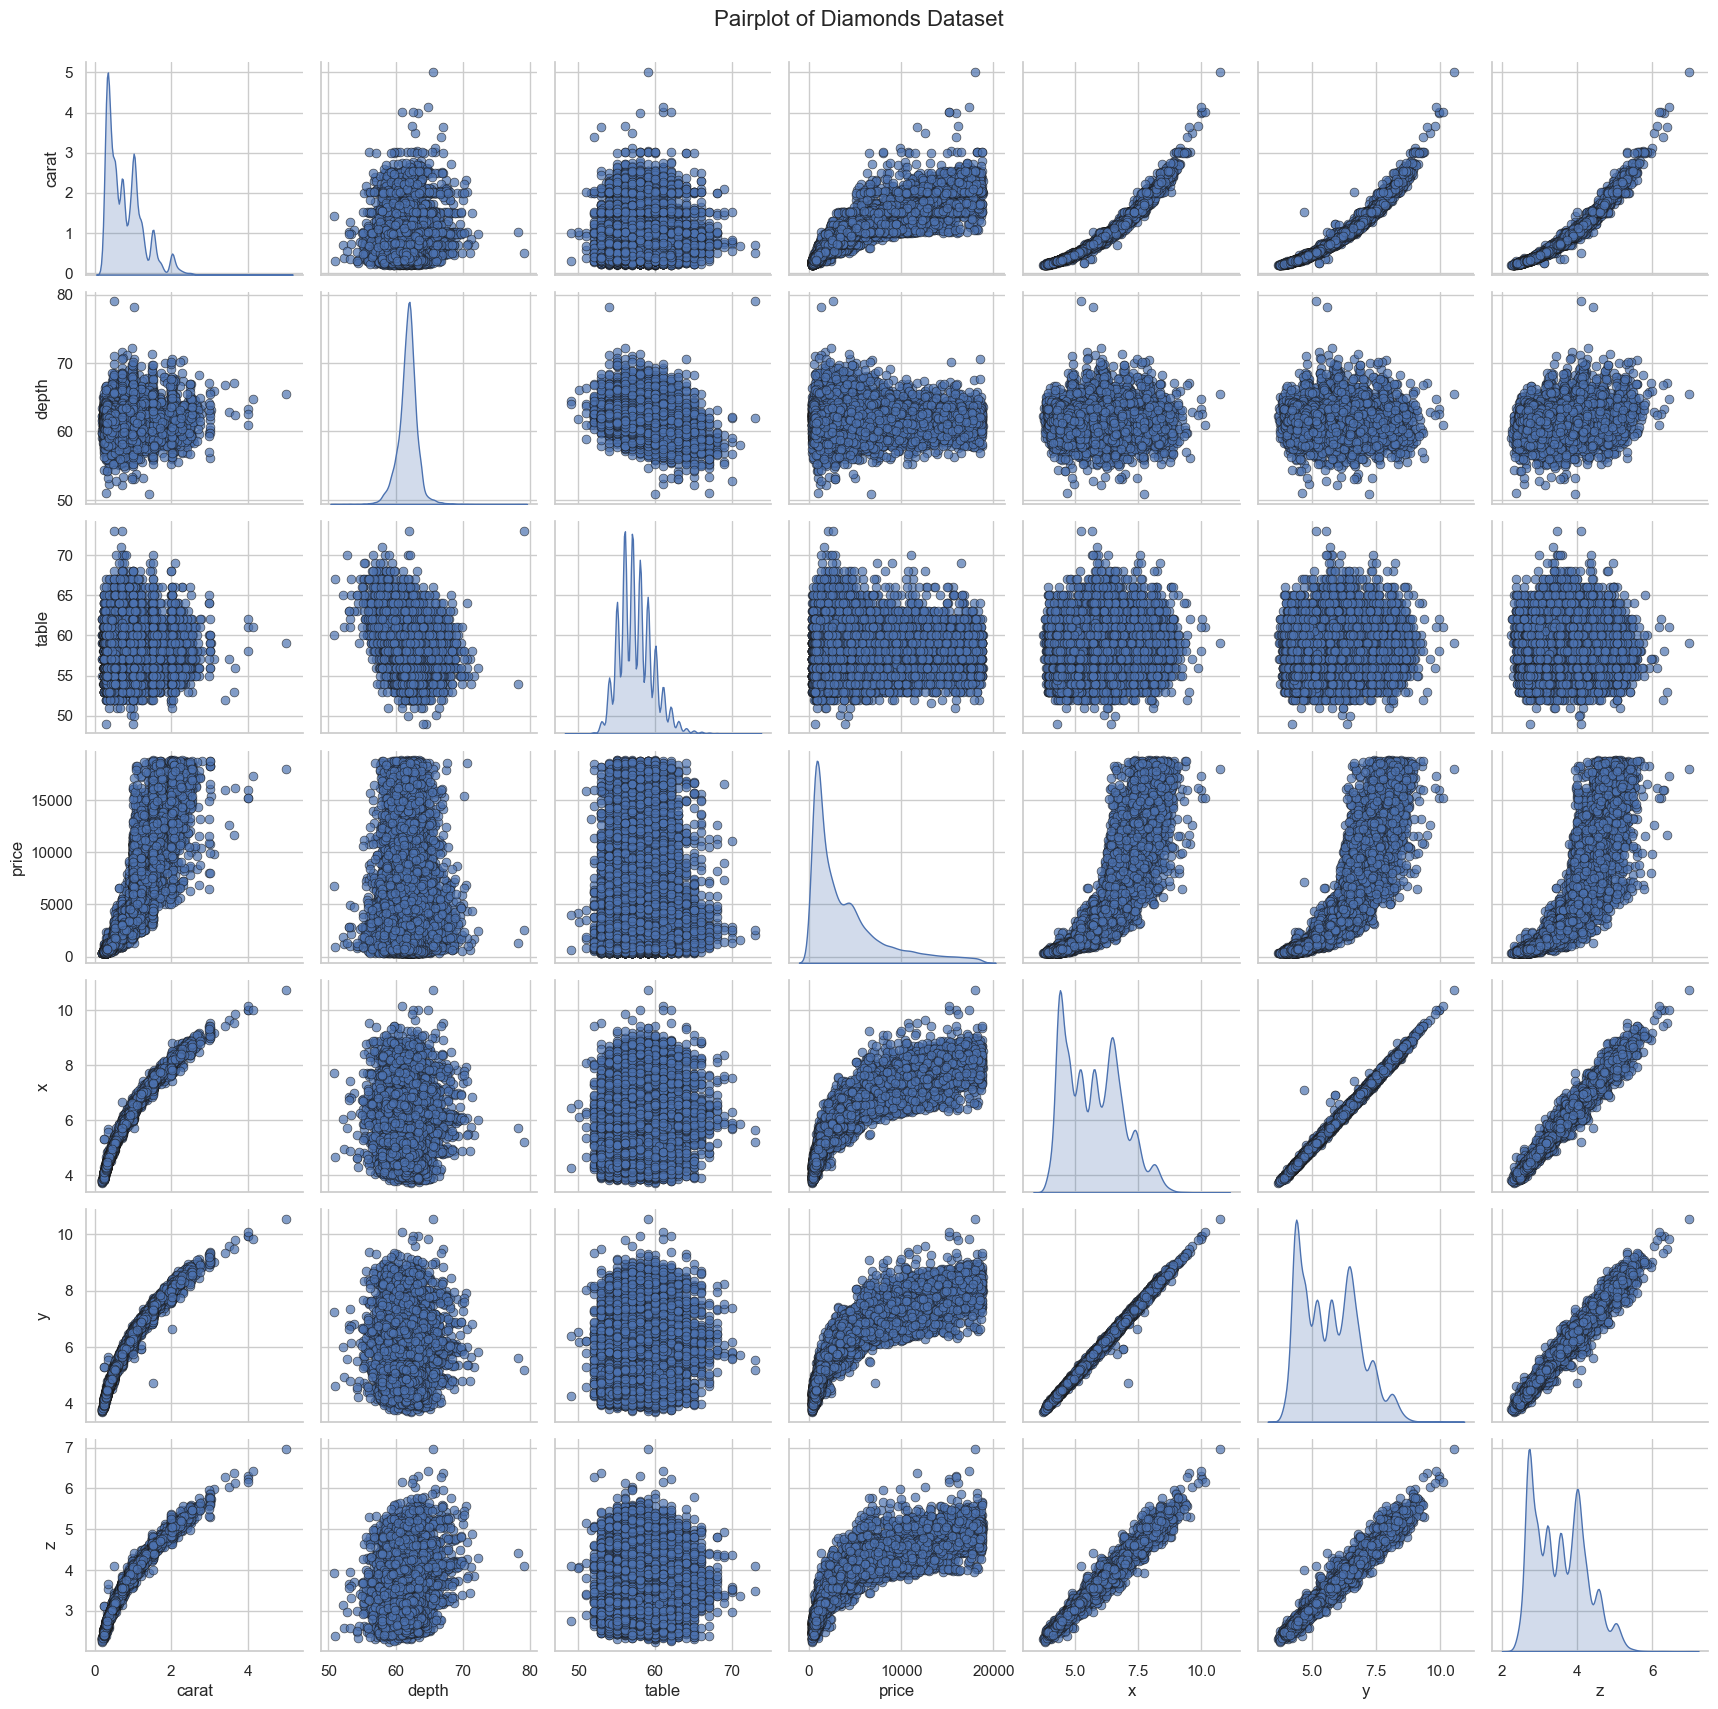

In [20]:
custom_palette = sns.color_palette("viridis")

pairplot = sns.pairplot(
    diamonds.select_dtypes("number"),
    diag_kind='kde',
    palette=custom_palette,
    plot_kws={'alpha': 0.7, 's': 40, 'edgecolor': 'k'}
)

pairplot.fig.suptitle('Pairplot of Diamonds Dataset', fontsize=16)
pairplot.fig.subplots_adjust(top=0.95)

plt.show()

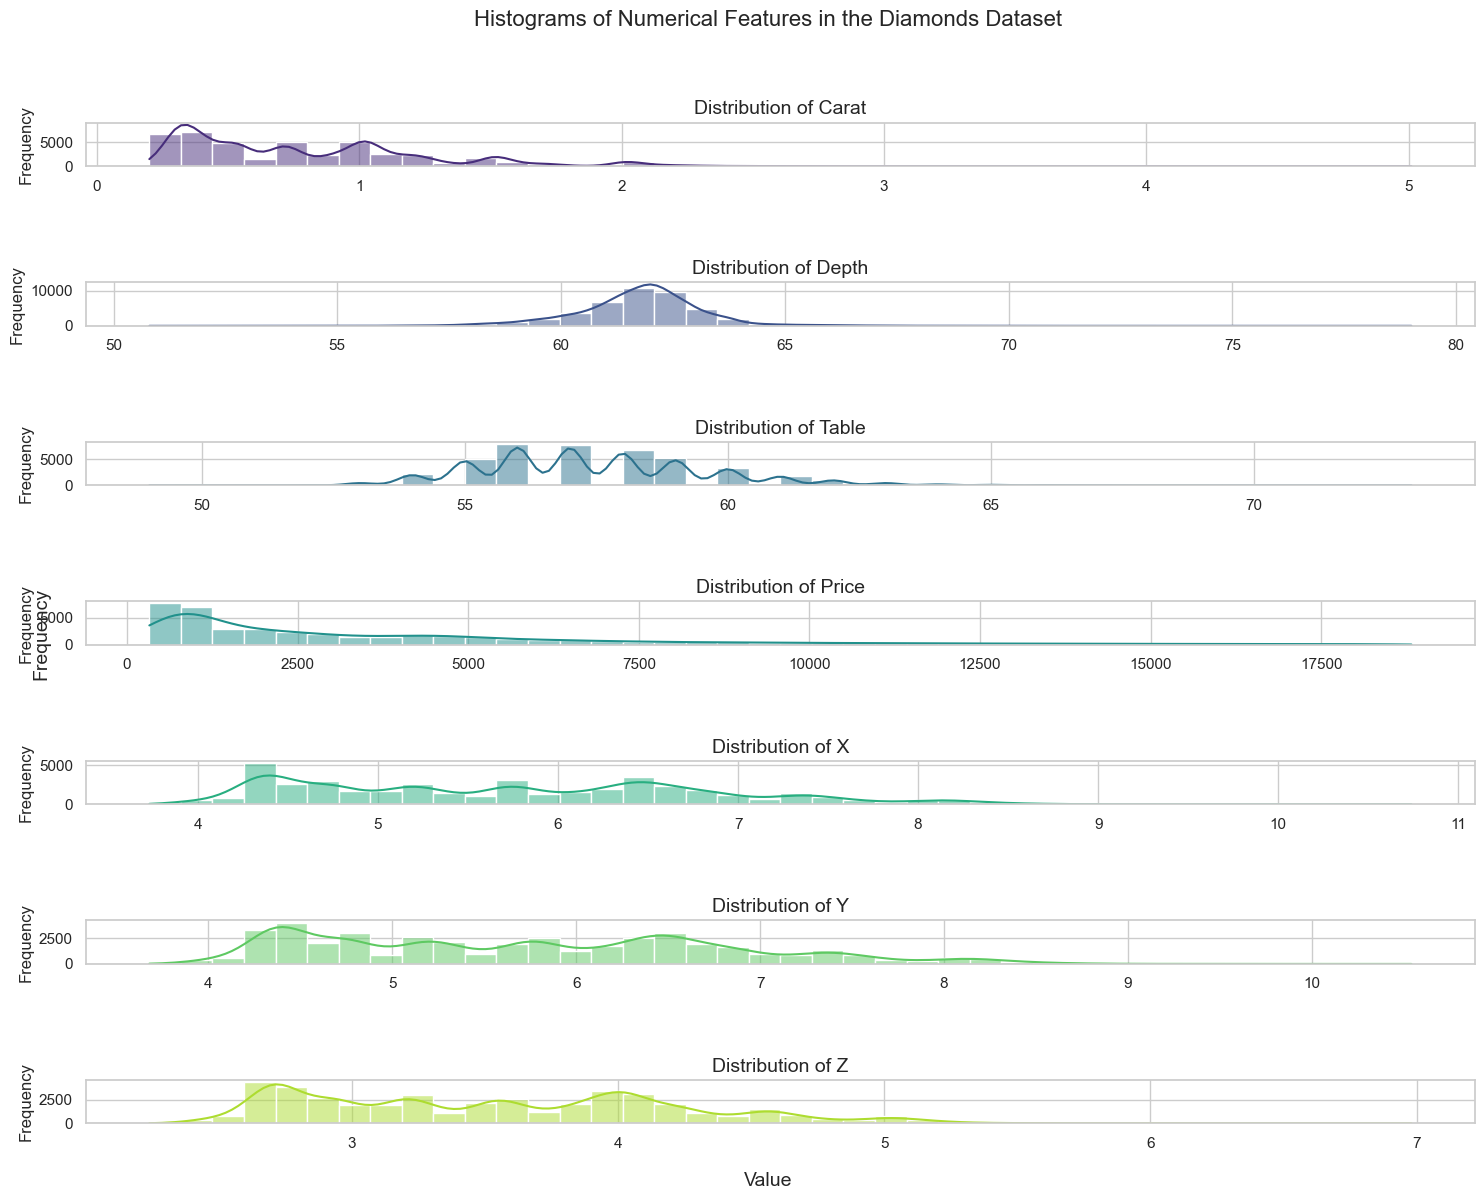

In [21]:
numerical_cols = diamonds.select_dtypes(include='number').columns

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(16, 12))
fig.tight_layout(pad=5.0)

custom_palette = sns.color_palette("viridis", len(numerical_cols))

for ax, col, color in zip(axes, numerical_cols, custom_palette):
    sns.histplot(diamonds[col], bins=40, ax=ax, color=color, kde=True)
    ax.set_title(f'Distribution of {col.capitalize()}', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.grid(True)

fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Histograms of Numerical Features in the Diamonds Dataset', fontsize=16, y=1.02)

plt.show()

Let's take a closer look to the price

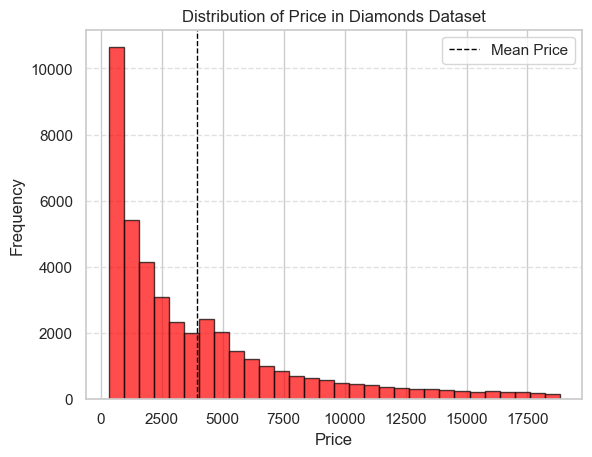

In [22]:
plt.hist(diamonds["price"], bins=30, color="red", edgecolor="black", alpha=0.7) 
mean_price = diamonds["price"].mean()
plt.axvline(x=mean_price, color="black", linestyle="dashed", linewidth=1, label="Mean Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price in Diamonds Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.6) 

plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))  # Adjust format string as needed

plt.legend()

plt.show()

Since the mean is greater than median for price, the distribution is right-skewed. So, it will be better to perform log to the price column.

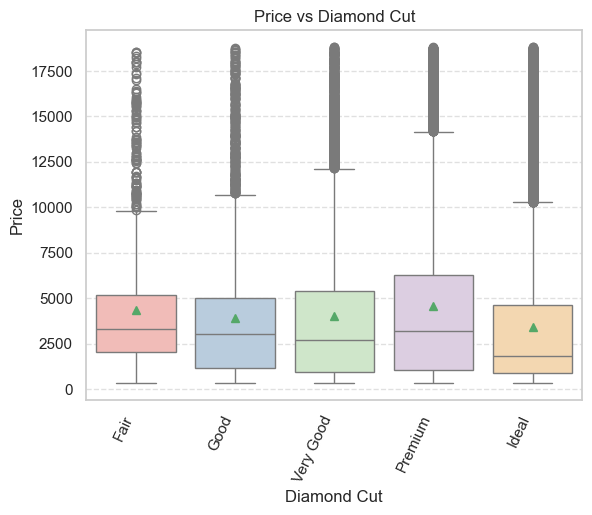

In [23]:
sns.boxplot(
    x = "cut",
    y = "price",
    showmeans=True, 
    order=cut_order,
    data=diamonds,
    palette="Pastel1"  
)

plt.xticks(rotation=65, ha="right") 

plt.title("Price vs Diamond Cut")
plt.xlabel("Diamond Cut")
plt.ylabel("Price")
plt.grid(axis="y", linestyle="--", alpha=0.6) 

plt.show()

In [24]:
diamond_stats = (
    diamonds.groupby("cut")
    .agg(
        count=("price", "count"),
        Min_Price=("price", "min"),
        Average_Price=("price", lambda x: round(x.mean(), 2)),
        Max_Price=("price", "max"),
    )
    .reset_index()
)

diamond_stats["percentage"] = round((diamond_stats["count"] / diamond_stats["count"].sum()) * 100, 3)

diamond_stats = diamond_stats.sort_values(by="cut")

diamond_stats = diamond_stats[
    ["cut", "count", "percentage", "Min_Price", "Average_Price", "Max_Price"]
]

table_data = diamond_stats.to_dict(orient="records")
column_names = {
    "cut": "Diamond Cut",
    "count": "Count",
    "percentage": "Percentage",
    "Min_Price": "Minimum Price",
    "Average_Price": "Average Price",
    "Max_Price": "Maximum Price",
}

print("--------Diamond Prices by Cut--------")
print(pd.DataFrame(table_data).rename(columns=column_names).sort_values(by="Count").to_string(index=False))

--------Diamond Prices by Cut--------
Diamond Cut  Count  Percentage  Minimum Price  Average Price  Maximum Price
       Fair   1281       2.978          337.0        4335.38        18574.0
       Good   3872       9.000          327.0        3929.22        18788.0
  Very Good   9646      22.422          336.0        3993.67        18818.0
    Premium  11071      25.734          334.0        4585.77        18823.0
      Ideal  17151      39.867          326.0        3438.10        18806.0


The most of the diamonds belong to ideal cut type.

Although the best cut type is Ideal, its price is the lowest. According to the average prices, the most expensive diamonds belong to Premium and Fair cut types. These results present that cut is not enough to explain response variable price, since price does not increase while cut feature improves.

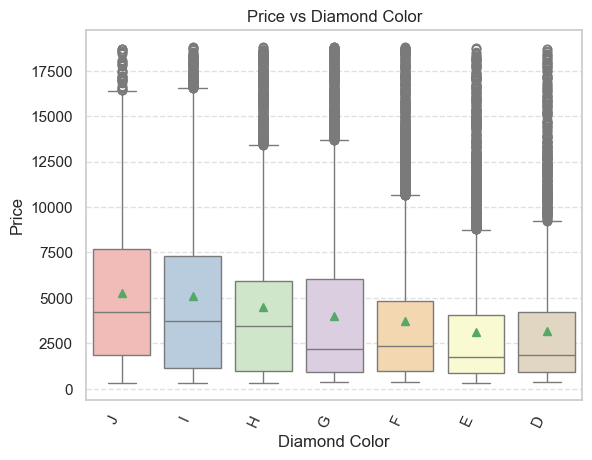

In [25]:
sns.boxplot(
    x = "color",
    y = "price",
    showmeans=True, 
    order=color_order,
    data=diamonds,
    palette="Pastel1"  
)

plt.xticks(rotation=65, ha="right") 

plt.title("Price vs Diamond Color")
plt.xlabel("Diamond Color")
plt.ylabel("Price")
plt.grid(axis="y", linestyle="--", alpha=0.6) 

plt.show()

In [26]:
diamond_stats = (
    diamonds.groupby("color")
    .agg(
        count=("price", "count"),
        Min_Price=("price", "min"),
        Average_Price=("price", lambda x: round(x.mean(), 2)),
        Max_Price=("price", "max"),
    )
    .reset_index()
)

diamond_stats["percentage"] = round((diamond_stats["count"] / diamond_stats["count"].sum()) * 100, 3)

diamond_stats = diamond_stats.sort_values(by="color")

diamond_stats = diamond_stats[
    ["color", "count", "percentage", "Min_Price", "Average_Price", "Max_Price"]
]

table_data = diamond_stats.to_dict(orient="records")
column_names = {
    "color": "Diamond Color",
    "count": "Count",
    "percentage": "Percentage",
    "Min_Price": "Minimum Price",
    "Average_Price": "Average Price",
    "Max_Price": "Maximum Price",
}

print("--------Diamond Prices by Color--------")
print(pd.DataFrame(table_data).rename(columns=column_names).sort_values(by="Count").to_string(index=False))

--------Diamond Prices by Color--------
Diamond Color  Count  Percentage  Minimum Price  Average Price  Maximum Price
            J   2283       5.307          339.0        5275.89        18710.0
            I   4252       9.884          334.0        5121.73        18823.0
            D   5410      12.575          357.0        3167.27        18693.0
            H   6620      15.388          337.0        4476.54        18803.0
            F   7610      17.689          342.0        3720.73        18791.0
            E   7809      18.152          326.0        3096.59        18731.0
            G   9037      21.006          354.0        3976.81        18818.0


The most of the diamonds belong to G color type.

Although the best color type is D, its price is one of the lowest. According to the average prices, the most expensive diamonds belong to J and I cut types which are actually the worst two color type in this dataset. These results present that color is not enough to explain response variable price, since price does not increase while color feature improves.



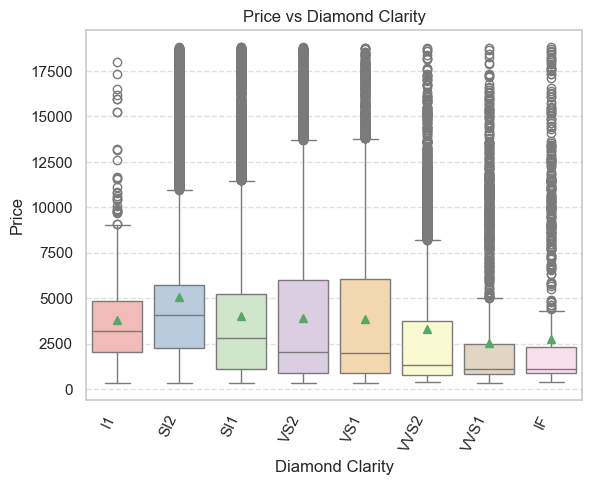

In [27]:
sns.boxplot(
    x = "clarity",
    y = "price",
    showmeans=True, 
    order=clarity_order,
    data=diamonds,
    palette="Pastel1"  
)

plt.xticks(rotation=65, ha="right") 

plt.title("Price vs Diamond Clarity")
plt.xlabel("Diamond Clarity")
plt.ylabel("Price")
plt.grid(axis="y", linestyle="--", alpha=0.6) 

plt.show()

In [28]:
diamond_stats = (
    diamonds.groupby("clarity")
    .agg(
        count=("price", "count"),
        Min_Price=("price", "min"),
        Average_Price=("price", lambda x: round(x.mean(), 2)),
        Max_Price=("price", "max"),
    )
    .reset_index()
)

diamond_stats["percentage"] = round((diamond_stats["count"] / diamond_stats["count"].sum()) * 100, 3)

diamond_stats = diamond_stats.sort_values(by="clarity")

diamond_stats = diamond_stats[
    ["clarity", "count", "percentage", "Min_Price", "Average_Price", "Max_Price"]
]

table_data = diamond_stats.to_dict(orient="records")
column_names = {
    "clarity": "Diamond Clarity",
    "count": "Count",
    "percentage": "Percentage",
    "Min_Price": "Minimum Price",
    "Average_Price": "Average Price",
    "Max_Price": "Maximum Price",
}

print("--------Diamond Prices by Clarity--------")
print(pd.DataFrame(table_data).rename(columns=column_names).sort_values(by="Count").to_string(index=False))


--------Diamond Prices by Clarity--------
Diamond Clarity  Count  Percentage  Minimum Price  Average Price  Maximum Price
             I1    605       1.406          345.0        3815.28        18018.0
             IF   1440       3.347          369.0        2766.53        18806.0
           VVS1   2898       6.736          336.0        2532.32        18777.0
           VVS2   4029       9.365          354.0        3317.75        18768.0
            VS1   6457      15.009          327.0        3848.02        18795.0
            SI2   7393      17.185          326.0        5059.07        18804.0
            VS2   9800      22.780          334.0        3895.73        18823.0
            SI1  10399      24.172          337.0        4000.58        18818.0


The most of the diamonds belong to SI1 clarity type.

Although the best clarity type is IF, its price is the lowest. According to the average prices, the most expensive diamonds belong to SI2 clarity types which is actually the second worst clarity type in this dataset. These results present that clarity is not enough to explain response variable price, since price does not increase while clarity feature improves.



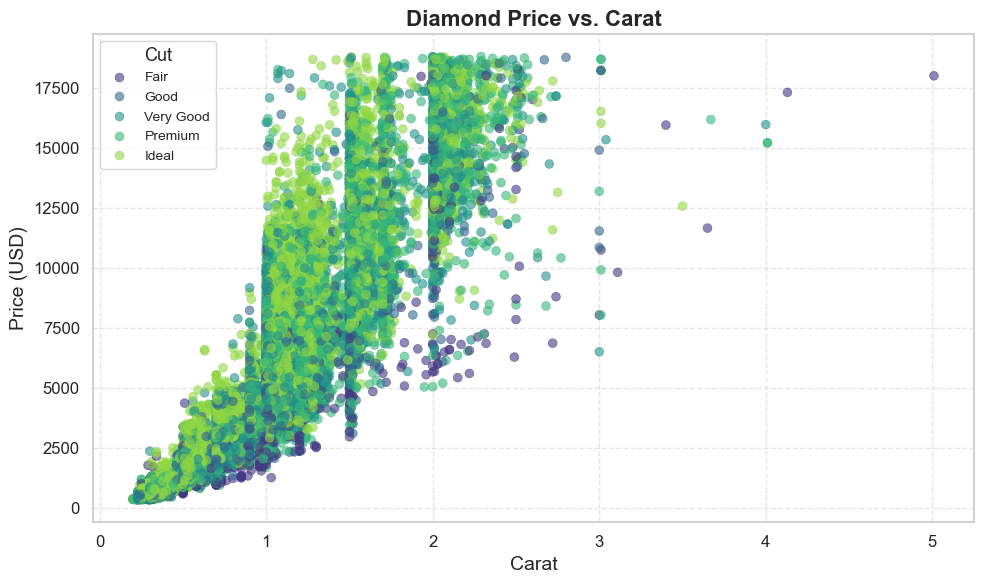

In [29]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=diamonds, 
    x='carat', 
    y='price', 
    hue='cut', 
    hue_order=cut_order, 
    palette='viridis', 
    alpha=0.6, 
    edgecolor=None,
    s=40
)

plt.title('Diamond Price vs. Carat', fontsize=16, weight='bold')
plt.xlabel('Carat', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(title='Cut', title_fontsize='13', fontsize='10', loc='upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

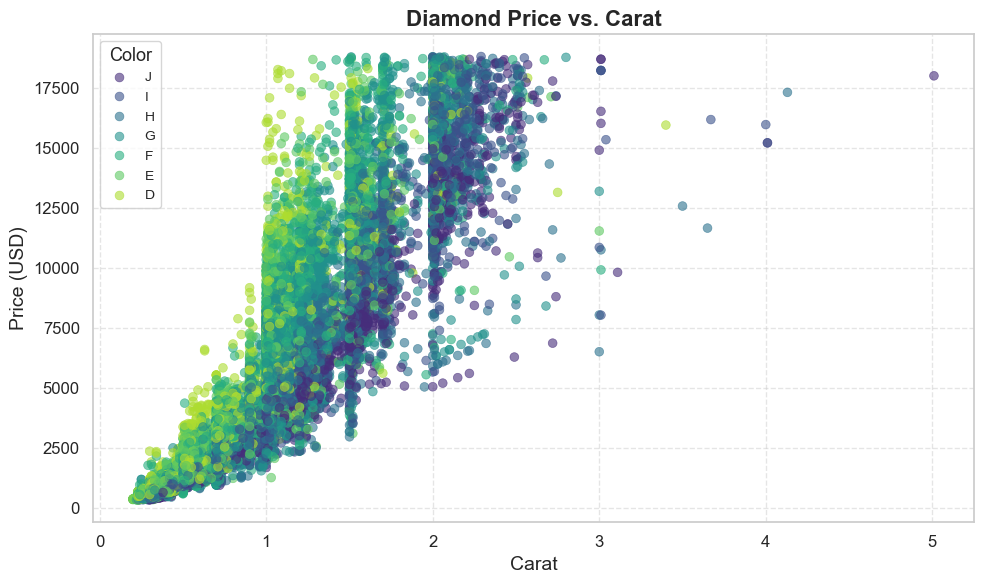

In [30]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=diamonds, 
    x='carat', 
    y='price', 
    hue='color', 
    hue_order=color_order,
    palette='viridis', 
    alpha=0.6, 
    edgecolor=None,
    s=40
)

plt.title('Diamond Price vs. Carat', fontsize=16, weight='bold')
plt.xlabel('Carat', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(title='Color', title_fontsize='13', fontsize='10', loc='upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

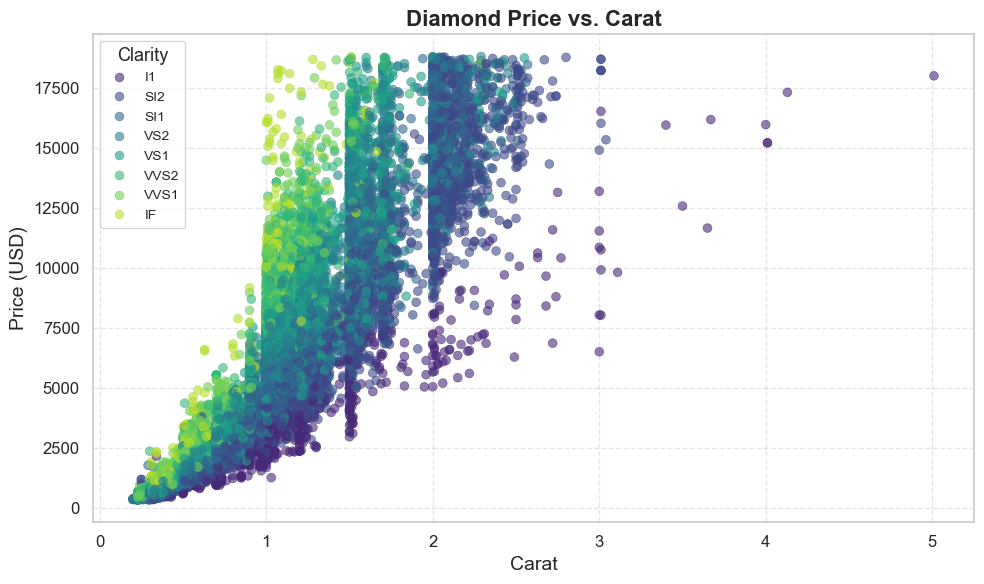

In [31]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=diamonds, 
    x='carat', 
    y='price', 
    hue='clarity', 
    hue_order=clarity_order, 
    palette='viridis', 
    alpha=0.6, 
    edgecolor=None,
    s=40
)

plt.title('Diamond Price vs. Carat', fontsize=16, weight='bold')
plt.xlabel('Carat', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(title='Clarity', title_fontsize='13', fontsize='10', loc='upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

When comparing diamonds with equal carat weight, IF clarity type is the most expensive, as expected.

When comparing diamonds with equal carat weight, Ideal cut type is the most expensive, as expected.

When comparing diamonds with equal carat weight, D color group is the most expensive, as expected.

It can be said that, while color, cut, and clarity alone are not meaningful for estimating price, they gain meaning with carat information.

In [32]:
d  = diamonds.copy()

In [33]:
X_train = diamonds.copy()
y_train = diamonds.pop("price")
pd.Series(
    mutual_info_regression(X=X_train.select_dtypes("number"), y=y_train, random_state=42),
    index=X_train.select_dtypes("number").columns,
)

carat    1.923729
depth    0.033158
table    0.055564
price    8.353249
x        1.466375
y        1.467796
z        1.419147
dtype: float64

In [34]:
kMeans = KMeans(n_clusters=5, random_state=42)

diamonds["cluster"] = kMeans.fit_predict(diamonds[["carat"]])
diamonds["cluster"] = diamonds["cluster"].astype("str")

pd.DataFrame(
    kMeans.cluster_centers_,
    index=kMeans.get_feature_names_out(),
    columns=["clusterCenter"],
).sort_values("clusterCenter")

,clusterCenter
kmeans0,0.344219
kmeans3,0.632940
kmeans2,1.051183
kmeans1,1.522600
kmeans4,2.121310


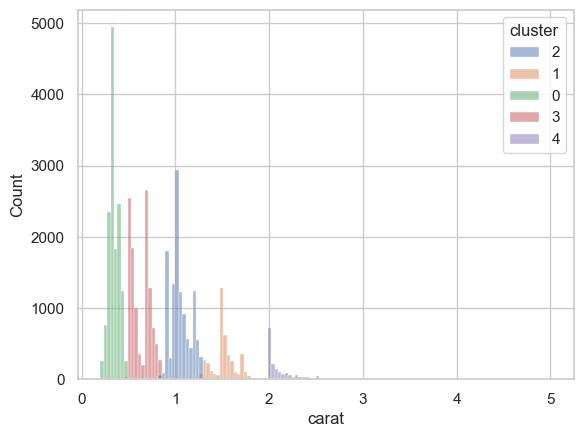

In [35]:
sns.histplot(data=diamonds, x="carat", hue="cluster")
plt.show()

Findings:
1) A strong linear correlation exists between our target and (carat, x, y, z which are in turn all strongly correlated)
2) mutual_info_regression shows no difference in relation between features from correlation
3) Distribution plot of carat shows many peaks and can be clustered

## Feature engineering

In [36]:
diamonds_test = pd.DataFrame(pd.read_csv("test.csv"))

In [37]:
diamonds = d.copy()

In [38]:
for df in [diamonds, diamonds_test]:
    df["xyRatio"] = df["x"] / df["y"]

diamonds['price'] = np.log(diamonds['price'])

In [39]:
kMeans = KMeans(n_clusters=5, random_state=42)
diamonds["cluster"] = kMeans.fit_predict(diamonds[["carat"]])
diamonds_test["cluster"] = kMeans.predict(diamonds_test[["carat"]])

diamonds["cluster"] = diamonds["cluster"].astype("str")
diamonds_test["cluster"] = diamonds_test["cluster"].astype("str")

clusterOrder = [
    cluster.removeprefix("kmeans")
    for cluster in list(
        pd.DataFrame(
            kMeans.cluster_centers_,
            index=kMeans.get_feature_names_out(),
            columns=["clusterCenter"],
        )
        .sort_values("clusterCenter")
        .index
    )
]

In [40]:
isolationForest = IsolationForest(contamination=0.001, random_state= 42)
indexToRemove = []

for cluster in list(diamonds['cluster'].unique()):
    diamondsCluster = diamonds[diamonds['cluster']==cluster]
    outliers = pd.Series(isolationForest.fit_predict(diamondsCluster[['carat']]))
    outliersIndex = list(outliers[outliers == -1].index)
    indexToRemove += outliersIndex

diamonds = diamonds.drop(set(indexToRemove))

## Model Training

In [41]:
X_train = diamonds.copy()
y_train = X_train.pop("price")

In [42]:
numCol = ["carat", "depth", "table", "z","xyRatio"]

numPipeline = Pipeline([
    ("imputerNumNan", SimpleImputer(strategy="mean")),
    ("imputerNumZero", SimpleImputer(missing_values=0, strategy="mean")),
    ("standardizerNum", StandardScaler()),
    ])
cutPipeline = Pipeline([
    ("imputerCutNan", SimpleImputer(strategy="most_frequent")),
    ("imputerCutZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["Fair", "Good", "Very Good", "Premium", "Ideal"]])),
    ])
colorPipeline = Pipeline([
    ("imputerColorNan", SimpleImputer(strategy="most_frequent")),
    ("imputerColorZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["J", "I", "H", "G", "F", "E", "D"]])),
    ])
clarityPipeline = Pipeline([
    ("imputerClarityNan", SimpleImputer(strategy="most_frequent")),
    ("imputerClarityZero", SimpleImputer(missing_values=0, strategy="most_frequent")),
    ("ordinalEncoderCut", OrdinalEncoder(categories=[["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]])),
    ])
clusterPipeline = Pipeline([
    ("ordinalEncoderCluster", OrdinalEncoder(categories=[clusterOrder])),
    ])
fullPipeline = ColumnTransformer([
    ("numPipeline", numPipeline, numCol),
    ("cutPipeline", cutPipeline, ["cut"]),
    ("colorPipeline", colorPipeline, ["color"]),
    ("clarityPipeline", clarityPipeline, ["clarity"]),
    ("clusterPipeline", clusterPipeline, ["cluster"]),
    ])

### Findings:

1) After trying many regressor, Many promising ones showed up such as:

[LGBMRegressor, ExtraTreesRegressor, CatBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor,
XGBRegressor, BaggingRegressor]

2) A VotingRegressor is trained with all previous models after optimizing them individually using (RandomizedSearchCV, GridSearchCV)

In [43]:
lGBMRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("lGBMRegModel",LGBMRegressor(random_state=42, n_jobs=-1, boosting_type="gbdt", max_depth=50, num_leaves=47, max_bin=665, num_iterations=131))])

exTreesRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("exTreesRegModel", ExtraTreesRegressor(random_state= 42, n_estimators=450, n_jobs=-1, min_samples_split=7, min_samples_leaf=4, max_depth=44))])

histGradBooRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("histGradBooRegModel", HistGradientBoostingRegressor(random_state= 42, max_depth= 12, max_leaf_nodes= 61, min_samples_leaf= 14))])

ranForRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("ranForRegModel", RandomForestRegressor(random_state= 42, max_depth = 14, n_estimators= 700))])

xgboostModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("xgboostModel", XGBRegressor(max_depth= 5, reg_alpha= 88, reg_lambda= .7, colsample_bytree= .9, min_child_weight= 3))])

bagRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("bagRegModel", BaggingRegressor(random_state=42, n_estimators=43))])

catBoRegModel = Pipeline([
    ("fullPipeline", fullPipeline),
    ("catBoRegModel", CatBoostRegressor(random_state=42))])

votRegModel = VotingRegressor(
    estimators=[
        ("ranForRegModel", ranForRegModel),
        ("xgboostModel", xgboostModel),
        ("bagRegModel", bagRegModel),
        ("exTreesRegModel", exTreesRegModel),
        ("histGradBooRegModel", histGradBooRegModel),
        ("lGBMRegModel", lGBMRegModel),
        ("catBoRegModel", catBoRegModel),
    ], n_jobs=3)

votRegModel = VotingRegressor(
    estimators=[
        ("ranForRegModel", ranForRegModel),
        ("xgboostModel", xgboostModel),
        ("bagRegModel", bagRegModel),
        ("exTreesRegModel", exTreesRegModel),
        ("histGradBooRegModel", histGradBooRegModel),
        ("lGBMRegModel", lGBMRegModel),
        ("catBoRegModel", catBoRegModel),
    ], n_jobs=3)

In [44]:
votRegModel.fit(X=X_train, y=y_train)
scores = cross_val_score(estimator=votRegModel, X=X_train, y=y_train, scoring="neg_root_mean_squared_error", cv=10)
print(pd.DataFrame(scores).describe().transpose().round(2))

train_data_predictions = votRegModel.predict(X_train)
mse = mean_squared_error(train_data_predictions, y_train, squared=False)
print(mse)

   count  mean  std   min   25%   50%   75%   max
0   10.0 -0.08  0.0 -0.09 -0.08 -0.08 -0.08 -0.08
0.06450868298304904


In [45]:
ID=diamonds_test['Id']
price=votRegModel.predict(diamonds_test.drop('Id',axis=1))
data={'ID':ID,'price':np.exp(price)}
sub=pd.DataFrame(data)
sub.to_csv('sub.csv',index=False)